## Библиотеки

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import distance
import json
import os, sys
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.api_client import ResponseHandlingException, UnexpectedResponse
import uuid
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.optimizers import * 
from tensorflow.keras import utils 
from tensorflow.keras.applications import *

2024-04-28 17:53:57.491194: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-28 17:53:57.887930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Датасет

In [2]:
PATH_DATA_IMG = '/environment/data/images_train'
PATH_DATA_LBL = '/environment/data/labels_train'
SHIFT = 200
!ls /environment/data

encoder_ConvNeXtTiny.keras  images_train  labels_train
images_100		    labels_100	  store


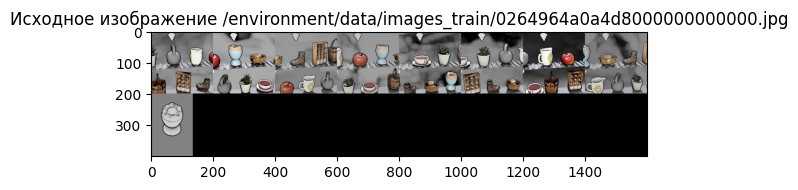

In [3]:
path_img = PATH_DATA_IMG + os.sep + os.listdir(PATH_DATA_IMG)[5]
plt.title(f'Исходное изображение {path_img}')
img = np.asarray(Image.open(path_img))
plt.imshow(img)
plt.show()

In [4]:
path = PATH_DATA_LBL + os.sep + os.listdir(PATH_DATA_LBL)[5]
with open(path,'r') as f:
    data = json.load(f)
data

{'version': '5.2.1',
 'flags': {},
 'shapes': [{'label': 'true object',
   'points': [[248.82154882154882, 42.42424242424242],
    [295.6228956228956, 114.47811447811448]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '0264964a0a4d8000000000000.jpg',
 'imageData': None,
 'imageHeight': 400,
 'imageWidth': 1600}

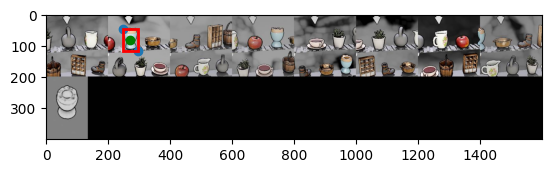

In [5]:
fig, ax = plt.subplots()
ax.imshow(img)

x1, y1 = data['shapes'][0]['points'][0]
x2, y2 = data['shapes'][0]['points'][1]
width = x2 - x1
height = y2 - y1
ax.scatter([x1, x2],[y1, y2])
ax.scatter([x1//2+x2//2],[y1//2+y2//2], c='g')
rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

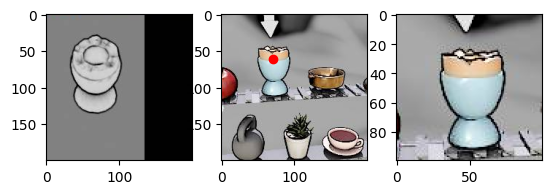

(120, 100, 3)

In [6]:
plt.subplot(131)
plt.imshow(img[200:,:200])
plt.subplot(132)
n = int(x1/SHIFT%8) # номер картинки
plt.imshow(img[:SHIFT,n*SHIFT:n*SHIFT + SHIFT,:])
plt.scatter(70, 60, c='r')
plt.subplot(133)
plt.imshow(img[:SHIFT,n*SHIFT:n*SHIFT + SHIFT,:][20:120,20:120])
plt.show()
img[220:340,20:120].shape

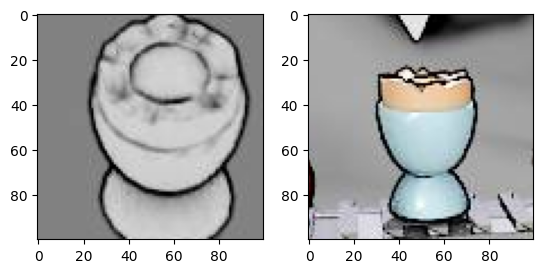

In [7]:
def get_images(path: str) -> list:
    img = np.asarray(Image.open(path))
    weights = np.array([0.2989, 0.5870, 0.1140])
    card = img[230:330,10:110,:]
    #card = np.dot(card, weights)
    cards = [card]
    n = 0
    
    while img.shape[1] > n*SHIFT:
        card = img[:SHIFT,n*SHIFT:n*SHIFT + SHIFT,:][20:120,20:120]
        #card = np.dot(card, weights)
        cards += [card]
        n += 1
    return cards

cards = get_images(PATH_DATA_IMG + os.sep + os.listdir(PATH_DATA_IMG)[5])

plt.subplot(121)
plt.imshow(cards[0])
plt.subplot(122)
plt.imshow(cards[2])
plt.show()


## Модели

In [57]:
models_app = {
#    'ConvNeXtBase': 'convnext',
#    'ConvNeXtLarge': 'convnext',
#    'ConvNeXtSmall': 'convnext',
    'ConvNeXtTiny': 'convnext',
#    'ConvNeXtXLarge': 'convnext',
    'DenseNet121': 'densenet',
 #   'DenseNet169': 'densenet',
 #   'DenseNet201': 'densenet',
    'EfficientNetB0': 'efficientnet',
  #  'EfficientNetB1': 'efficientnet',
  #  'EfficientNetB2': 'efficientnet',
  #  'EfficientNetB3': 'efficientnet',
  #  'EfficientNetB4': 'efficientnet',
  #  'EfficientNetB5': 'efficientnet',
  #  'EfficientNetB6': 'efficientnet',
  #  'EfficientNetB7': 'efficientnet',
    'EfficientNetV2B0': 'efficientnet_v2',
  #  'EfficientNetV2B1': 'efficientnet_v2',
  #  'EfficientNetV2B2': 'efficientnet_v2',
  #  'EfficientNetV2B3': 'efficientnet_v2',
  #  'EfficientNetV2L': 'efficientnet_v2',
  #  'EfficientNetV2M': 'efficientnet_v2',
  #  'EfficientNetV2S': 'efficientnet_v2',
    'InceptionResNetV2': 'inception_resnet_v2',
     'InceptionV3': 'inception_v3',
    'MobileNet': 'mobilenet',
    'MobileNetV2': 'mobilenet_v2',
  #  'MobileNetV3Large': 'mobilenet_v3',
    'MobileNetV3Small': 'mobilenet_v3',
   # 'NASNetLarge': 'nasnet',
    'NASNetMobile': 'nasnet',
    'RegNetX002': 'regnet',
   # 'RegNetX004': 'regnet',
   # 'RegNetX006': 'regnet',
   # 'RegNetX008': 'regnet',
   # 'RegNetX016': 'regnet',
   # 'RegNetX032': 'regnet',
   # 'RegNetX040': 'regnet',
   # 'RegNetX064': 'regnet',
   # 'RegNetX080': 'regnet',
   # 'RegNetX120': 'regnet',
   # 'RegNetX160': 'regnet',
   # 'RegNetX320': 'regnet',
    'RegNetY002': 'regnet',
   # 'RegNetY004': 'regnet',
   # 'RegNetY006': 'regnet',
   # 'RegNetY008': 'regnet',
   # 'RegNetY016': 'regnet',
   # 'RegNetY032': 'regnet',
   # 'RegNetY040': 'regnet',
   # 'RegNetY064': 'regnet',
   # 'RegNetY080': 'regnet',
   # 'RegNetY120': 'regnet',
   # 'RegNetY160': 'regnet',
   # 'RegNetY320': 'regnet',
   # 'ResNet101': 'resnet',
   # 'ResNet101V2': 'resnet_v2',
   # 'ResNet152': 'resnet',
   # 'ResNet152V2': 'resnet_v2',
    'ResNet50': 'resnet',
    'ResNet50V2': 'resnet_v2',
   # 'ResNetRS101': 'resnet_rs',
   # 'ResNetRS152': 'resnet_rs',
   # 'ResNetRS200': 'resnet_rs',
   # 'ResNetRS270': 'resnet_rs',
   # 'ResNetRS350': 'resnet_rs',
   # 'ResNetRS420': 'resnet_rs',
    'ResNetRS50': 'resnet_rs',
    'VGG16': 'vgg16',
   # 'VGG19': 'vgg19',
    'Xception': 'xception'
}

2024-04-28 17:54:05.340525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-28 17:54:05.380864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-28 17:54:05.381057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-28 17:54:05.383506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-28 17:54:05.383656: I tensorflow/compile

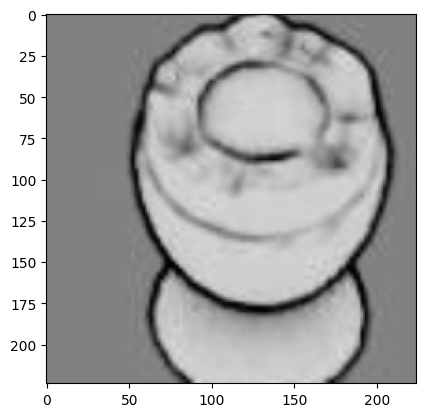

In [9]:
def preproc(img:np.array, procname, shape=(224, 224)):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, shape).numpy()
    img = eval(procname).preprocess_input(img)
    return img

plt.imshow(preproc(cards[0], 'convnext'))
plt.show()

## Тест

In [10]:
def add_ncolor(data):
    color = 'TN'
    if data['target'] == 1 and data['predict'] == 0:
        color = 'FP'
    elif data['target'] == 0 and data['predict'] == 1:
        color = 'FN'
    elif data['target'] == 1 and data['predict'] == 1:
        color = 'TP'
    elif data['origin'] == 1:
        color = 'Origin'
    data['color'] = color

    return data

In [11]:
def calc_score(y_test, y_pred):
    accuracy = []
    for y, p in zip(y_test, y_pred):
        accuracy += [p == y]
    if not len(accuracy): return 0
    score = sum(accuracy)/len(accuracy)
    return score

In [49]:
def get_listdir(path: str, count=None):
    listdir = os.listdir(path)
    if count is None: return listdir
    if count > 0:
        listdir = listdir[:count]
    elif count < 0:
        listdir = listdir[count:]
    
    return listdir

In [60]:
def testing(model, preprocess, count=None, verbose=False, dirlabel=PATH_DATA_LBL, dirdata=PATH_DATA_IMG) -> tuple:
    y_pred = []
    y_test = []
    data_test = []
    listdir = get_listdir(PATH_DATA_LBL, count)

    for i, fname in enumerate(listdir):
       
        
        with open(dirlabel + os.sep + fname,'r') as f:
            data = json.load(f)
            
        cards = get_images(dirdata + os.sep + data['imagePath'])
        x1 = data['shapes'][0]['points'][0][0]
        n = int(x1/SHIFT%(len(cards)-1)) + 1
        k = n + 1 if n < len(cards)-1 else 1
        
        y_test += [n-1]
        tensors = np.array([preprocess(i) for i in cards])
        embeddings = model.predict(tensors, verbose=0)
        
        vector = embeddings[0].flatten()
        distances = [distance.euclidean(vector, e.flatten()) for e in embeddings[1:]]
        y_pred += [np.argmin(distances)]
        
        otp = {}
        for j, v in enumerate(embeddings):
            if 0 == j: otp['origin'] = tensors[j]
            if n == j: otp['target'] = tensors[j]
            if j == (y_pred[-1] + 1): otp['predict'] = tensors[j]
                
            data_test.append({
                'vector': v,
                'data':{
                    #'image': numpy_image_to_base64(cards[j]),
                    'target': 1 if j == n else 0,
                    'origin': 1 if j == 0 else 0,
                    'predict': 1 if j == (y_pred[-1] + 1) else 0,
                    'file_name': fname,
                    'card_number': j,
                    'file_index': i
                }
            })
        
        score = calc_score(y_test, y_pred)
        print(i+1, fname, end=f' {100*score:.2f}%\r', sep='. ')
        
        if verbose:
            for j, k in enumerate(['origin', 'target', 'predict']):
                plt.subplot(131 + j)
                plt.title(k.title())
                plt.imshow(otp[k])
            plt.show()


        
    return y_test, y_pred, data_test
    

2024-04-28 17:54:10.842561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-04-28 17:54:11.423587: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xa2a1060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-28 17:54:11.423619: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-04-28 17:54:11.968314: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-04-28 17:54:11.986297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


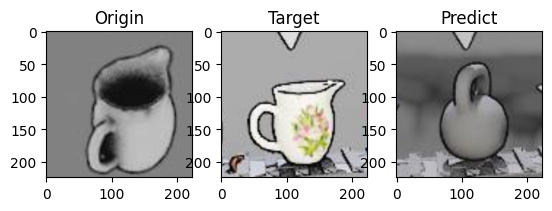

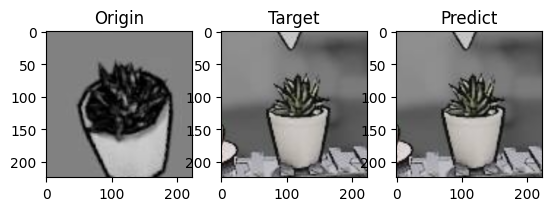

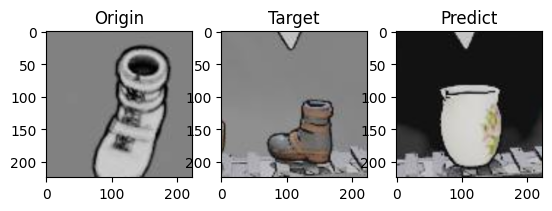

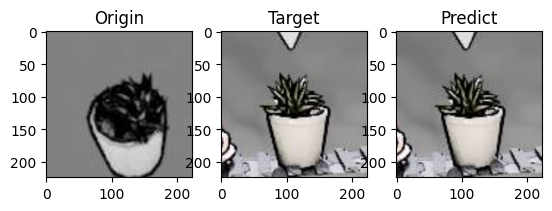

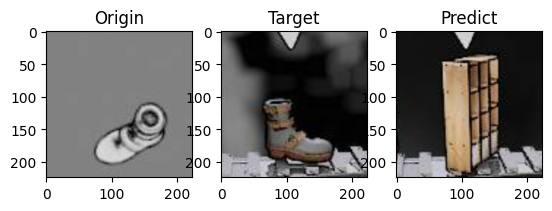

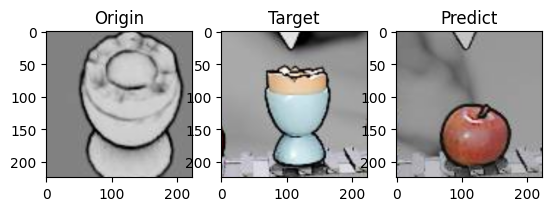

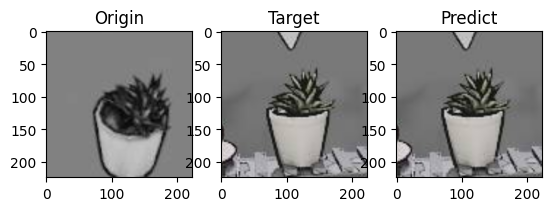

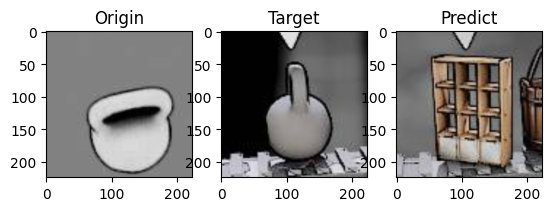

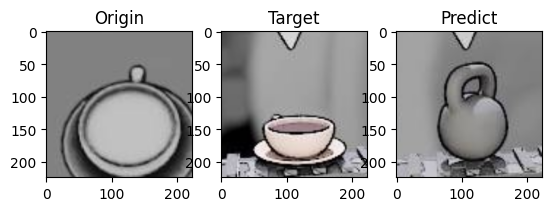

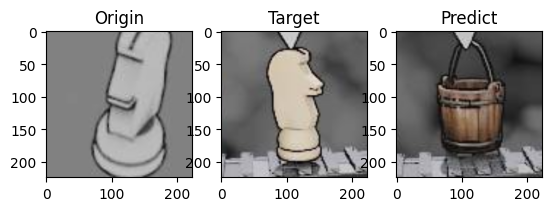

In [13]:
pre_encoder = eval('ConvNeXtTiny')(weights='imagenet', include_top=False, pooling='max',input_shape=(224, 224, 3))
y_test, y_pred, data_test = testing(pre_encoder, lambda x: preproc(x, procname='convnext'), 10, verbose=True)

In [14]:
def load_qdrant(data_test, name, size, dist, chunk_size=500):
    
    def chunk_data(data, chunk_size=chunk_size):
        for i in range(0, len(data), chunk_size):
            yield data[i:i + chunk_size]
        
    for chunk_data_test in chunk_data(data_test):    
        
        # Подключение к Qdrant
        qdrant = QdrantClient("http://vectorstore:6333/")

        try:
            qdrant.create_collection(collection_name=name, 
                                         vectors_config=models.VectorParams(size=size, 
                                                                            distance=dist))
        except: pass

        qdrant.upsert(collection_name=name,
                points=models.Batch(
                    ids=[str(uuid.uuid4()) for _ in chunk_data_test],
                    vectors=[i['vector'].tolist() for i in chunk_data_test],
                    payloads=[add_ncolor(i['data']) or i['data'] for i in chunk_data_test],
                    )
                )

'''
{
  "limit": 900,
  "color_by": "color"
}
'''

'\n{\n  "limit": 900,\n  "color_by": "color"\n}\n'

In [61]:
for i, (model_name, proc_name) in enumerate(models_app.items()):
    
    pre_encoder = eval(model_name)(weights='imagenet', include_top=False, pooling='avg',input_shape=(224, 224, 3))
    print(i+1, model_name, proc_name, pre_encoder.count_params())
    
    y_test, y_pred, data_test = testing(pre_encoder, lambda x: preproc(x, procname=proc_name), None)
    
    #size = len(data_test[0]['vector'])
    #load_qdrant(data_test, f'v3__{model_name}__100', size, models.Distance.EUCLID)
    
    print()
    print()

1 ConvNeXtTiny convnext 27820128
3998. f59d63b94e554000000000000.json 19.51%

2 DenseNet121 densenet 7037504
3998. f59d63b94e554000000000000.json 25.06%

3 EfficientNetB0 efficientnet 4049571
3998. f59d63b94e554000000000000.json 16.23%

4 EfficientNetV2B0 efficientnet_v2 5919312
3998. f59d63b94e554000000000000.json 17.31%

5 InceptionResNetV2 inception_resnet_v2 54336736
3998. f59d63b94e554000000000000.json 16.43%

6 InceptionV3 inception_v3 21802784
3998. f59d63b94e554000000000000.json 23.61%

7 MobileNet mobilenet 3228864
3998. f59d63b94e554000000000000.json 24.06%

8 MobileNetV2 mobilenet_v2 2257984
3998. f59d63b94e554000000000000.json 22.16%

9 MobileNetV3Small mobilenet_v3 939120
3998. f59d63b94e554000000000000.json 16.93%

10 NASNetMobile nasnet 4269716
3998. f59d63b94e554000000000000.json 27.44%

11 RegNetX002 regnet 2336640
3998. f59d63b94e554000000000000.json 18.08%

12 RegNetY002 regnet 2814844
3998. f59d63b94e554000000000000.json 16.91%

13 ResNet50 resnet 23587712
3998. f59

## Обучение

In [62]:
base_model = 'Xception'
base_proc = models_app[base_model]
base_model, base_proc

('Xception', 'xception')

In [63]:
pre_encoder = eval(base_model)(weights='imagenet', include_top=False, pooling='avg',input_shape=(224, 224, 3))
y_test, y_pred, data_test = testing(pre_encoder, lambda x: preproc(x, procname=base_proc), 100)
size = len(data_test[0]['vector'])
load_qdrant(data_test, f'base_{base_model}', size, models.Distance.EUCLID)

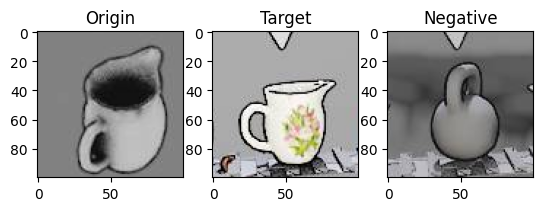

In [64]:
def get_dataset(count=100) -> list:
    pairs = []
    listdir = get_listdir(PATH_DATA_LBL, count)
        
    for i, fname in enumerate(listdir):
        
        with open(PATH_DATA_LBL + os.sep + fname,'r') as f:
            data = json.load(f)
        
        cards = get_images(PATH_DATA_IMG + os.sep + data['imagePath'])
        x1 = data['shapes'][0]['points'][0][0]
        n = int(x1/SHIFT%(len(cards)-1)) + 1
        k = (n+1) if (1+n) < len(cards) else 1
        pairs.append((cards[0], cards[n], cards[k]))
        
    return pairs
    
images = get_dataset(1)
image = images[0]
plt.subplot(131)
plt.title('Origin')
plt.imshow(image[0])
plt.subplot(132)
plt.title('Target')
plt.imshow(image[1])
plt.subplot(133)
plt.title('Negative')
plt.imshow(image[2])
plt.show()

In [65]:
# Выборка
def get_generators(count, preprocessor, shape=(100, 100, 1), batch=32) -> tuple:
            
    def process_imgs(count):
        images = get_dataset(count)
        for orig, target, neg in images:
            orig   = preprocessor(orig)
            target = preprocessor(target)
            neg    = preprocessor(neg)
            yield (orig, target), 1.
            yield (orig, neg), 0.
          

    # Функция для создания генератора
    def generator(count, shape):
        return tf.data.Dataset.from_generator(process_imgs, output_signature=(
            (tf.TensorSpec(shape=shape, dtype=tf.float32),
            tf.TensorSpec(shape=shape, dtype=tf.float32)),
            tf.TensorSpec(shape=[], dtype=tf.float32),
        ), args=[count])

    # Создание генераторов
    test_data = generator(-count//4, shape).batch(batch)
    train_data = generator(count, shape).batch(batch)

    return train_data, test_data

train_gen, test_gen = get_generators(2048, lambda x: preproc(x, procname=base_proc), shape=(224, 224, 3), batch=32)

In [66]:
# Encoder
def get_encoder(dim=1024, shape=(224, 224, 3), model_name=base_model):  
    
    base_model = eval(model_name)(weights='imagenet', pooling='avg',include_top=False, input_shape=shape)
    base_model.trainable = False
    x = base_model.output
    x = Dense(dim, name='embedding')(x)
    return Model(inputs=base_model.input, outputs=x, name=f'encoder_base_{model_name}')


Model: "encoder_base_Xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_59 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_59[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_c

 ormalization)                                                                                    
                                                                                                  
 block4_sepconv2_act (Activ  (None, 28, 28, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 28, 28, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 28, 28, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
          

 ation)                                                                                           
                                                                                                  
 block7_sepconv1 (Separable  (None, 14, 14, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 14, 14, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 14, 14, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
          

 block9_sepconv3_bn (BatchN  (None, 14, 14, 728)          2912      ['block9_sepconv3[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 add_111 (Add)               (None, 14, 14, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_110[0][0]']             
                                                                                                  
 block10_sepconv1_act (Acti  (None, 14, 14, 728)          0         ['add_111[0][0]']             
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 14, 14, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D) 

                                                                                                  
 block12_sepconv3_act (Acti  (None, 14, 14, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 14, 14, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 14, 14, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_114 (

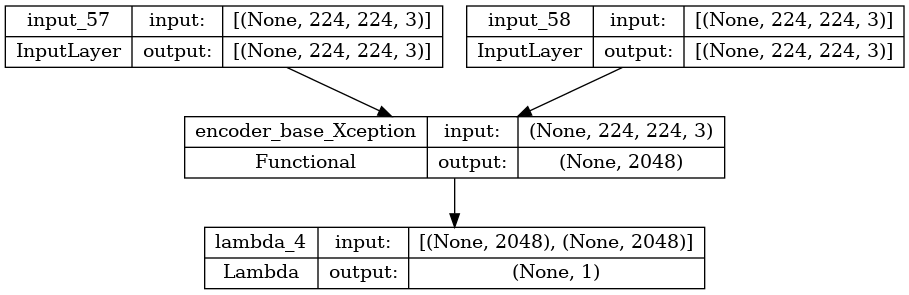

In [68]:
# Сиамская нейронная сеть
def get_siam(dim=1024, lr=0.001, shape=(100, 100, 1)):

    img_a = Input(shape=shape)
    img_b = Input(shape=shape)

    encoder = get_encoder(dim=dim, shape=shape)

    vecs_a = encoder(img_a)
    vecs_b = encoder(img_b)
    
    def euclidean_distance(vects):
        x, y = vects
        sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_square, K.epsilon()))

    euclidean = Lambda(euclidean_distance, output_shape=(dim, 1))([vecs_a, vecs_b])

    def loss_siam(margin=1.):
        def contrastive_loss(y_true, y_pred):
            square_pred = K.square(y_pred)
            margin_square = K.square(K.maximum(margin - y_pred, 0))
            return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
        return contrastive_loss
    
    def accuracy(y_true, y_pred):
        return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
    
    model = Model([img_a, img_b], euclidean)

    
    model.compile(optimizer=Adam(learning_rate=lr), loss=loss_siam())

    
    return model, encoder

model, encoder = get_siam(2048, shape=(224, 224, 3))
encoder.summary()
utils.plot_model(model, dpi=96, show_shapes=True)

In [69]:
#@title Колбэк визуализация
class Visual(Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10: return 
        y_test, y_pred, data_test = testing(encoder, lambda x: preproc(x, procname=base_proc), -100)
        size = len(data_test[0]['vector'])
        print(f'load_qdrant: {epoch+1:03}_{base_model}')
        load_qdrant(data_test, f'{epoch+1:03}_{base_model}', size, models.Distance.EUCLID)

In [70]:
# Обучение
h = model.fit(train_gen, epochs=3000, validation_data=test_gen, callbacks=[Visual(),
                                ReduceLROnPlateau(monitor='val_loss',
                                                  verbose=True,
                                                  factor=0.1,
                                                  patience=5,
                                                  min_lr=1e-7),
                                EarlyStopping(patience=20,
                                              monitor='val_loss',
                                              verbose=True,
                                              restore_best_weights=True),
                            ])

Epoch 1/3000
load_qdrant: 001_Xception00000.json 66.00%.16391. a97b5ad2ada54000000000000.json 100.00%
128/128 [==============================] - 61s 299ms/step - loss: 0.1639 - val_loss: 0.1356 - lr: 0.0010
Epoch 2/3000
128/128 [==============================] - 41s 238ms/step - loss: 0.1213 - val_loss: 0.1189 - lr: 0.0010
Epoch 3/3000
128/128 [==============================] - 43s 230ms/step - loss: 0.1057 - val_loss: 0.1085 - lr: 0.0010
Epoch 4/3000
128/128 [==============================] - 76s 353ms/step - loss: 0.0959 - val_loss: 0.1009 - lr: 0.0010
Epoch 5/3000
128/128 [==============================] - 48s 211ms/step - loss: 0.0891 - val_loss: 0.0954 - lr: 0.0010
Epoch 6/3000
128/128 [==============================] - 62s 344ms/step - loss: 0.0839 - val_loss: 0.0911 - lr: 0.0010
Epoch 7/3000
128/128 [==============================] - 80s 292ms/step - loss: 0.0798 - val_loss: 0.0877 - lr: 0.0010
Epoch 8/3000
128/128 [==============================] - 68s 274ms/step - loss: 0.0764

Epoch 64/3000
128/128 [==============================] - 46s 233ms/step - loss: 0.0433 - val_loss: 0.0610 - lr: 0.0010
Epoch 65/3000
128/128 [==============================] - 41s 220ms/step - loss: 0.0431 - val_loss: 0.0610 - lr: 0.0010
Epoch 66/3000
128/128 [==============================] - 44s 236ms/step - loss: 0.0429 - val_loss: 0.0609 - lr: 0.0010
Epoch 67/3000
128/128 [==============================] - 49s 251ms/step - loss: 0.0428 - val_loss: 0.0608 - lr: 0.0010
Epoch 68/3000
128/128 [==============================] - 59s 244ms/step - loss: 0.0426 - val_loss: 0.0608 - lr: 0.0010
Epoch 69/3000
128/128 [==============================] - 74s 315ms/step - loss: 0.0425 - val_loss: 0.0607 - lr: 0.0010
Epoch 70/3000
128/128 [==============================] - 68s 225ms/step - loss: 0.0423 - val_loss: 0.0607 - lr: 0.0010
Epoch 71/3000
load_qdrant: 071_Xception00000.json 97.00% ETA: 0s - loss: 0.04221. a97b5ad2ada54000000000000.json 100.00%
128/128 [==============================] - 61s

Epoch 125/3000
128/128 [==============================] - 39s 214ms/step - loss: 0.0337 - val_loss: 0.0558 - lr: 1.0000e-05
Epoch 126/3000
128/128 [==============================] - 38s 214ms/step - loss: 0.0337 - val_loss: 0.0558 - lr: 1.0000e-05
Epoch 127/3000
128/128 [==============================] - ETA: 0s - loss: 0.0337
Epoch 127: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
128/128 [==============================] - 65s 269ms/step - loss: 0.0337 - val_loss: 0.0558 - lr: 1.0000e-05
Epoch 128/3000
128/128 [==============================] - 63s 213ms/step - loss: 0.0336 - val_loss: 0.0558 - lr: 1.0000e-06
Epoch 129/3000
128/128 [==============================] - 43s 227ms/step - loss: 0.0336 - val_loss: 0.0558 - lr: 1.0000e-06
Epoch 130/3000
128/128 [==============================] - 39s 215ms/step - loss: 0.0336 - val_loss: 0.0558 - lr: 1.0000e-06
Epoch 131/3000
load_qdrant: 131_Xception00000.json 97.00% ETA: 0s - loss: 0.03361. a97b5ad2ada54000000000000.js

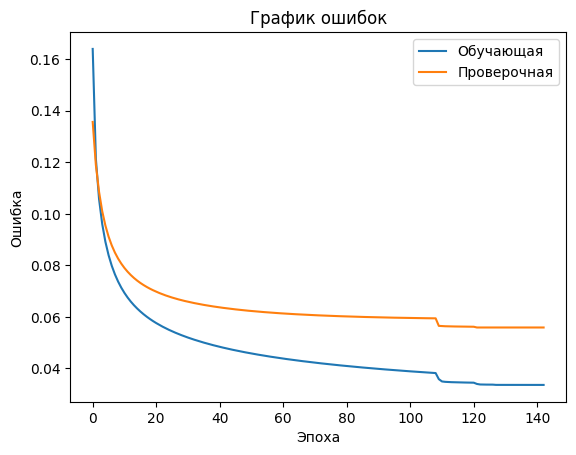

In [83]:
# Графики обучения
plt.title('График ошибок')
plt.plot(h.history['loss'], label='Обучающая')
plt.plot(h.history['val_loss'], label='Проверочная')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [85]:
# save
encoder.save(f'/environment/data/encoder_{base_model}', save_format='tf')

INFO:tensorflow:Assets written to: /environment/data/encoder_Xception/assets


INFO:tensorflow:Assets written to: /environment/data/encoder_Xception/assets


In [74]:
# fintal score Xception
y_test, y_pred, data_test = testing(encoder, lambda x: preproc(x, procname=base_proc), -(3998-2048), dirlabel=PATH_DATA_LBL, dirdata=PATH_DATA_IMG)
size = len(data_test[0]['vector'])
load_qdrant(data_test, f'trained_{base_model}', size, models.Distance.EUCLID)